In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import dateutil.parser
import datetime
from scipy.optimize import curve_fit
from scipy.stats import expon
import math

In [36]:
# 68,335,729 data points in total
import random
p = 0.0001  # 0.01% of the lines -> 6800 data points
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
"""
df = pd.read_csv(
         'data/all_events.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
"""
# df = pd.read_csv('../data/Kiasma_sorted.csv', nrows=1000000, low_memory=False)
df = pd.read_csv('../data/AaltoyliopistoMKorkeakouluaukio_sorted.csv')

## Drop duplicated based on timestamp

In [37]:
df = df.drop_duplicates('ts').reset_index()

## Add some useful columns

In [121]:
# sort based on timestamp
df = df.sort_values('ts')
# the hour and minutes of the timestamp
df['hour_and_minutes'] = df['ts'].apply(lambda x: x[11:16])
# month of timestamp
df['month'] = df['ts'].apply(lambda x: x[5:7])
# the percentage of bikes
df['bikes_percent'] = df['bikes'] / df['total_slots']
df['minutes_from_midnight'] = df['ts'].apply(lambda x: int(x[11:13]) * 60 + int(x[14:16]))
# df['hour'] = df['hour_and_minutes'].apply(lambda x: x[:2])
df['date'] = df['ts'].apply(pd.to_datetime)
df['hour'] = df.date.apply(lambda x: x.hour)
df['weekday'] = df['date'].apply(lambda x: x.weekday())
df['weekend'] = df['weekday'].apply(lambda x: x > 4)
df.head()

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s)
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3


## Explore 

In [39]:
df.shape

(128023, 17)

In [40]:
df.describe()

,index,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight,weekday
count,128023.000000,1.280230e+05,1.280230e+05,128023.0,128023.0,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000
mean,64879.642674,6.018431e+01,2.482667e+01,1.0,541.0,7.830398,40.599752,0.192926,732.632800,3.040883
std,38422.483995,4.872211e-11,6.656390e-11,0.0,0.0,9.516940,0.489950,0.234671,404.983005,1.993114
min,0.000000,6.018431e+01,2.482667e+01,1.0,541.0,0.000000,40.000000,0.000000,0.000000,0.000000
25%,32005.500000,6.018431e+01,2.482667e+01,1.0,541.0,1.000000,40.000000,0.024390,388.000000,1.000000
50%,64011.000000,6.018431e+01,2.482667e+01,1.0,541.0,4.000000,41.000000,0.097561,734.000000,3.000000
75%,96016.500000,6.018431e+01,2.482667e+01,1.0,541.0,12.000000,41.000000,0.292683,1081.000000,5.000000
max,142935.000000,6.018431e+01,2.482667e+01,1.0,541.0,60.000000,41.000000,1.463415,1439.000000,6.000000


In [41]:
df.head(10)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,hour,date,weekday,weekend
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468,07,2018-05-11 07:48:01,4,False
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469,07,2018-05-11 07:49:01,4,False
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470,07,2018-05-11 07:50:01,4,False
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471,07,2018-05-11 07:51:01,4,False
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472,07,2018-05-11 07:52:01,4,False
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,05,0.100,473,07,2018-05-11 07:53:01,4,False
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,05,0.100,474,07,2018-05-11 07:54:01,4,False
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,05,0.100,475,07,2018-05-11 07:55:01,4,False
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,05,0.100,476,07,2018-05-11 07:56:01,4,False
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,05,0.100,477,07,2018-05-11 07:57:01,4,False


In [42]:
by_hour = df.groupby('hour_and_minutes').mean()[0::60]
by_hour

,index,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight,weekday,weekend
hour_and_minutes,,,,,,,,,,,
00:00,70033.438356,60.184312,24.826671,1.0,541.0,2.602740,40.657534,0.064116,0.0,3.328767,0.369863
01:00,66275.750000,60.184312,24.826671,1.0,541.0,2.222222,40.597222,0.054887,60.0,3.250000,0.375000
02:00,64796.619718,60.184312,24.826671,1.0,541.0,2.591549,40.577465,0.063956,120.0,3.169014,0.338028
03:00,65809.197674,60.184312,24.826671,1.0,541.0,2.604651,40.604651,0.064180,180.0,3.011628,0.302326
04:00,64574.955556,60.184312,24.826671,1.0,541.0,5.022222,40.588889,0.123598,240.0,3.000000,0.288889
05:00,64400.750000,60.184312,24.826671,1.0,541.0,10.318182,40.590909,0.254164,300.0,2.931818,0.272727
06:00,64976.793478,60.184312,24.826671,1.0,541.0,12.847826,40.597826,0.316576,360.0,3.021739,0.293478
07:00,65043.728261,60.184312,24.826671,1.0,541.0,13.152174,40.597826,0.324032,420.0,3.021739,0.293478
08:00,64410.591398,60.184312,24.826671,1.0,541.0,12.827957,40.591398,0.315978,480.0,3.032258,0.290323


Text(0.5,1,'Bikes percentage each hour')

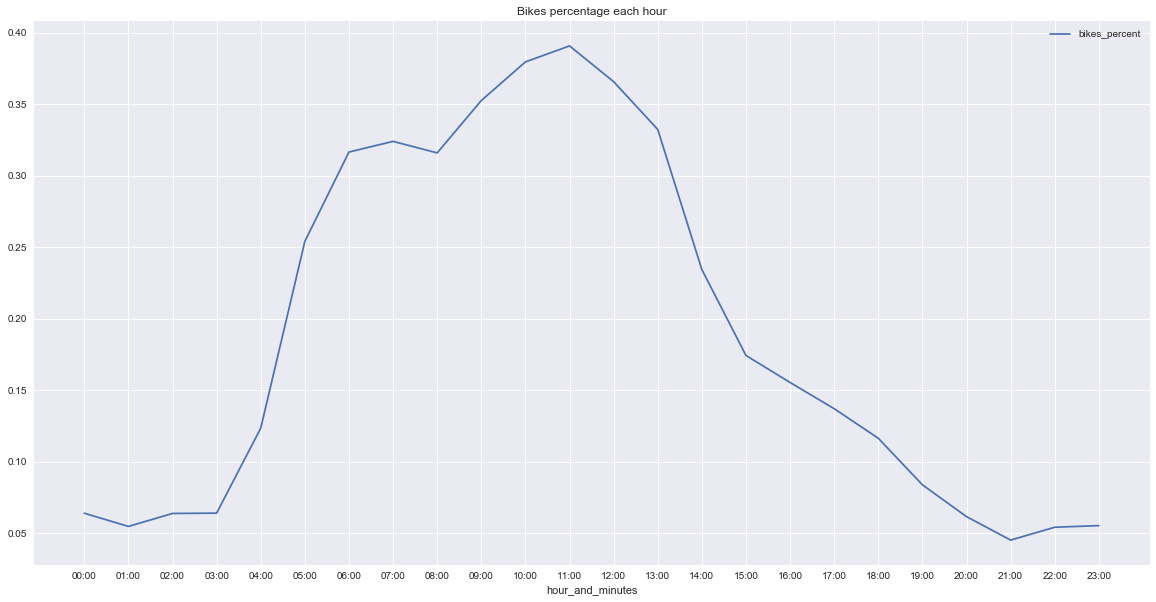

In [43]:
fig, ax = plt.subplots(figsize=(20,10))
by_hour.plot(y='bikes_percent', ax=ax)
ax.set_xticks(range(len(by_hour.index)))
ax.set_xticklabels(by_hour.index)
plt.title('Bikes percentage each hour')

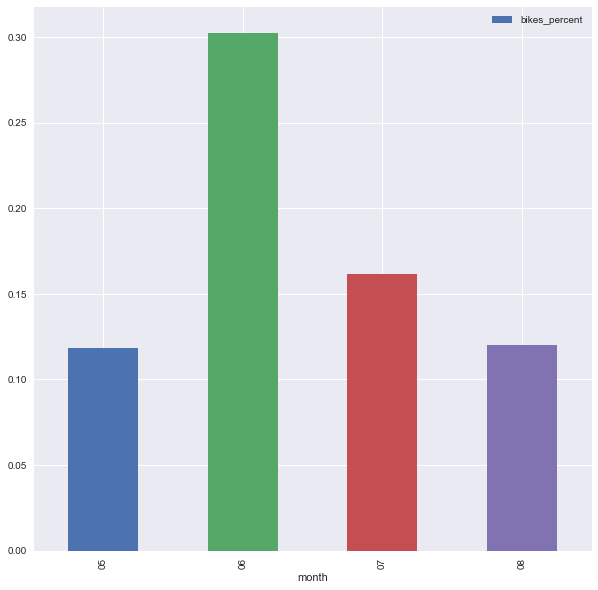

In [44]:
by_month = df.groupby('month').mean()
by_month.plot(y='bikes_percent', kind='bar', figsize=(10, 10))

In [45]:
# this is useful when using data from several stations
by_name = df.groupby('name').mean()
by_name

,index,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight,weekday,weekend
name,,,,,,,,,,,
"Aalto-yliopisto (M), Korkeakouluaukio",64879.642674,60.184312,24.826671,1.0,541.0,7.830398,40.599752,0.192926,732.6328,3.040883,0.292229


## Prepare for predictions

### Add column which states whether a bike was added at a given moment

In [46]:
df['bike_added'] = df.apply(lambda x: df.iloc[(x.name - 1 if x.name > 0 else 0)]['bikes'] < x['bikes'] , axis=1)
df['bike_removed'] = df.apply(lambda x: df.iloc[(x.name - 1 if x.name > 0 else 0)]['bikes'] > x['bikes'] , axis=1)
df.head(100)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,hour,date,weekday,weekend,bike_added,bike_removed
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468,07,2018-05-11 07:48:01,4,False,False,False
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469,07,2018-05-11 07:49:01,4,False,False,True
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470,07,2018-05-11 07:50:01,4,False,False,False
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471,07,2018-05-11 07:51:01,4,False,False,False
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472,07,2018-05-11 07:52:01,4,False,False,False
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,05,0.100,473,07,2018-05-11 07:53:01,4,False,False,False
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,05,0.100,474,07,2018-05-11 07:54:01,4,False,False,False
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,05,0.100,475,07,2018-05-11 07:55:01,4,False,False,False
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,05,0.100,476,07,2018-05-11 07:56:01,4,False,False,False
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,05,0.100,477,07,2018-05-11 07:57:01,4,False,False,False


### Add max and running waiting time for next bike

In [49]:
# extract difference in minutes to a separate column
# on the moment that a bike was added, the waiting time is the time to next bike
i = 0
first_non_additive_index = 0
while (i < len(df)):
    while (i < len(df) and df.iloc[i]['bike_added'] == False):
        i += 1
    if (i >= len(df)):
        break
    additive_row = df.iloc[i]
    time = additive_row['minutes_from_midnight']
    difference = abs(time - df.iloc[first_non_additive_index]['minutes_from_midnight'])
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'max_wait_for_new_bike'] = difference 
    date_time = additive_row['date']
    last_date = df.iloc[first_non_additive_index]['date']
    date_difference = abs((date_time - last_date).total_seconds() / 60)
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'max_wait_for_new_bike_as_date'] = date_difference 
    # also add running waiting time (not max)
    date_times_until_now = df.loc[first_non_additive_index:i-1, 'date']
    date_difference_1 = abs((date_time - date_times_until_now).apply(lambda x: x.total_seconds() / 60))
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'wait_for_new_bike_as_date'] = date_difference_1 
    first_non_additive_index = i
    i += 1
# if we can't know when the next bike will be added, fill with -1 for now
df = df.fillna(-1)
df.head(100)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,minutes_from_midnight,hour,date,weekday,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,...,468,07,2018-05-11 07:48:01,4,False,False,False,16.0,16.0,16.000000
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,...,469,07,2018-05-11 07:49:01,4,False,False,True,16.0,16.0,15.000000
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,...,470,07,2018-05-11 07:50:01,4,False,False,False,16.0,16.0,14.000000
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,...,471,07,2018-05-11 07:51:01,4,False,False,False,16.0,16.0,13.000000
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,...,472,07,2018-05-11 07:52:01,4,False,False,False,16.0,16.0,12.000000
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,...,473,07,2018-05-11 07:53:01,4,False,False,False,16.0,16.0,11.000000
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,...,474,07,2018-05-11 07:54:01,4,False,False,False,16.0,16.0,10.000000
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,...,475,07,2018-05-11 07:55:01,4,False,False,False,16.0,16.0,9.000000
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,...,476,07,2018-05-11 07:56:01,4,False,False,False,16.0,16.0,8.000000
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,...,477,07,2018-05-11 07:57:01,4,False,False,False,16.0,16.0,7.000000


### Add idle time for each station

In [50]:
i = 0
idle_for = 0
idle_for_as_date = 0
while (i < len(df)):
    row = df.iloc[i]
    previous_row = df.iloc[(i-1 if i > 0 else 0)]
    if (not row['bikes'] == previous_row['bikes']):
        idle_for = 0
        idle_for_as_date = 0
        df.loc[i, 'idle_for'] = idle_for
        df.loc[i, 'idle_for_as_date'] = idle_for_as_date        
        i+= 1
        continue
    time_now = row['minutes_from_midnight']
    time_last = previous_row['minutes_from_midnight']
    date_time_now = row['date']
    date_time_last = previous_row['date']
    idle_for += abs(time_now - time_last)
    secs = (date_time_now - date_time_last).total_seconds()
    idle_for_as_date += abs(secs / 60)
    df.loc[i, 'idle_for'] = idle_for
    df.loc[i, 'idle_for_as_date'] = idle_for_as_date
    i += 1
# if we can't know when the next bike will be taken, fill with -1 for now
df = df.fillna(-1)
df.head(50)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,date,weekday,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,idle_for,idle_for_as_date
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,...,2018-05-11 07:48:01,4,False,False,False,16.0,16.0,16.000000,0.0,0.000000
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,...,2018-05-11 07:49:01,4,False,False,True,16.0,16.0,15.000000,0.0,0.000000
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,...,2018-05-11 07:50:01,4,False,False,False,16.0,16.0,14.000000,1.0,1.000000
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,...,2018-05-11 07:51:01,4,False,False,False,16.0,16.0,13.000000,2.0,2.000000
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,...,2018-05-11 07:52:01,4,False,False,False,16.0,16.0,12.000000,3.0,3.000000
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,...,2018-05-11 07:53:01,4,False,False,False,16.0,16.0,11.000000,4.0,4.000000
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,...,2018-05-11 07:54:01,4,False,False,False,16.0,16.0,10.000000,5.0,5.000000
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,...,2018-05-11 07:55:01,4,False,False,False,16.0,16.0,9.000000,6.0,6.000000
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,...,2018-05-11 07:56:01,4,False,False,False,16.0,16.0,8.000000,7.0,7.000000
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,...,2018-05-11 07:57:01,4,False,False,False,16.0,16.0,7.000000,8.0,8.000000


In [51]:
df.head(100)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,date,weekday,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,idle_for,idle_for_as_date
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,...,2018-05-11 07:48:01,4,False,False,False,16.0,16.0,16.000000,0.0,0.000000
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,...,2018-05-11 07:49:01,4,False,False,True,16.0,16.0,15.000000,0.0,0.000000
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,...,2018-05-11 07:50:01,4,False,False,False,16.0,16.0,14.000000,1.0,1.000000
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,...,2018-05-11 07:51:01,4,False,False,False,16.0,16.0,13.000000,2.0,2.000000
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,...,2018-05-11 07:52:01,4,False,False,False,16.0,16.0,12.000000,3.0,3.000000
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,...,2018-05-11 07:53:01,4,False,False,False,16.0,16.0,11.000000,4.0,4.000000
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,...,2018-05-11 07:54:01,4,False,False,False,16.0,16.0,10.000000,5.0,5.000000
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,...,2018-05-11 07:55:01,4,False,False,False,16.0,16.0,9.000000,6.0,6.000000
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,...,2018-05-11 07:56:01,4,False,False,False,16.0,16.0,8.000000,7.0,7.000000
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,...,2018-05-11 07:57:01,4,False,False,False,16.0,16.0,7.000000,8.0,8.000000


In [52]:
df.describe()

,index,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight,weekday,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,idle_for,idle_for_as_date
count,128023.000000,1.280230e+05,1.280230e+05,128023.0,128023.0,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000
mean,64879.642674,6.018431e+01,2.482667e+01,1.0,541.0,7.830398,40.599752,0.192926,732.632800,3.040883,239.543691,95.268873,49.747743,146.433375,34.819797
std,38422.483995,4.872211e-11,6.656390e-11,0.0,0.0,9.516940,0.489950,0.234671,404.983005,1.993114,421.196981,133.995827,85.586928,441.413243,70.843195
min,0.000000,6.018431e+01,2.482667e+01,1.0,541.0,0.000000,40.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,32005.500000,6.018431e+01,2.482667e+01,1.0,541.0,1.000000,40.000000,0.024390,388.000000,1.000000,13.000000,13.000000,5.000000,2.000000,2.000000
50%,64011.000000,6.018431e+01,2.482667e+01,1.0,541.0,4.000000,41.000000,0.097561,734.000000,3.000000,28.000000,28.000000,13.000000,6.000000,6.000000
75%,96016.500000,6.018431e+01,2.482667e+01,1.0,541.0,12.000000,41.000000,0.292683,1081.000000,5.000000,102.000000,101.000000,42.000000,25.000000,24.000000
max,142935.000000,6.018431e+01,2.482667e+01,1.0,541.0,60.000000,41.000000,1.463415,1439.000000,6.000000,1400.000000,593.000000,593.000000,1937.000000,503.000000


### Add time for next bike take

Predict how much time for the next bike to be taken: max waiting time is not useful here.

In [53]:
i = 0
first_non_removing_index = 0
while (i < len(df)):
    while (i < len(df) and df.iloc[i]['bike_removed'] == False):
        i += 1
    if (i >= len(df)):
        break
    removing_row = df.iloc[i]
    time = removing_row['minutes_from_midnight']
    times_until_now = df.loc[first_non_removing_index:i-1, 'minutes_from_midnight']
    difference = abs(time - times_until_now)
    df.loc[first_non_removing_index:(i-1 if i > 0 else 0), 'wait_for_bike_taken'] = difference 
    date_time = removing_row['date']
    date_times_until_now = df.loc[first_non_removing_index:i-1, 'date']
    date_difference = abs((date_time - date_times_until_now).apply(lambda x: x.total_seconds() / 60))
    df.loc[first_non_removing_index:(i-1 if i > 0 else 0), 'wait_for_bike_taken_as_date'] = date_difference 
    first_non_removing_index = i
    i += 1
# if we can't know when the next bike will be taken, fill with -1 for now
df = df.fillna(-1)
df.head(50)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,idle_for,idle_for_as_date,wait_for_bike_taken,wait_for_bike_taken_as_date
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,...,False,False,False,16.0,16.0,16.000000,0.0,0.000000,1.0,1.000000
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,...,False,False,True,16.0,16.0,15.000000,0.0,0.000000,10.0,10.000000
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,...,False,False,False,16.0,16.0,14.000000,1.0,1.000000,9.0,9.000000
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,...,False,False,False,16.0,16.0,13.000000,2.0,2.000000,8.0,8.000000
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,...,False,False,False,16.0,16.0,12.000000,3.0,3.000000,7.0,7.000000
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,...,False,False,False,16.0,16.0,11.000000,4.0,4.000000,6.0,6.000000
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,...,False,False,False,16.0,16.0,10.000000,5.0,5.000000,5.0,5.000000
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,...,False,False,False,16.0,16.0,9.000000,6.0,6.000000,4.0,4.000000
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,...,False,False,False,16.0,16.0,8.000000,7.0,7.000000,3.0,3.000000
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,...,False,False,False,16.0,16.0,7.000000,8.0,8.000000,2.0,2.000000


### Add weather data

In [54]:
weather = pd.read_csv('../data/weather_all.csv')
weather.head()

,Year,m,d,Time,Time zone,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s)
0,2016,5,1,00:00,UTC,1.0,1027.1,85.0,0.0,5.8,3.5,50000.0,276.0,4.1,3.7
1,2016,5,1,01:00,UTC,3.0,1027.2,82.0,0.0,6.2,3.3,50000.0,280.0,4.4,3.7
2,2016,5,1,02:00,UTC,0.0,1027.3,82.0,0.0,5.8,2.9,50000.0,279.0,4.3,3.9
3,2016,5,1,03:00,UTC,0.0,1027.4,82.0,0.0,5.7,2.9,47870.0,259.0,3.0,2.2
4,2016,5,1,04:00,UTC,0.0,1027.6,78.0,0.0,7.0,3.3,45900.0,277.0,3.0,2.0


In [55]:
# fill missing values with the last known value
weather = weather.fillna(method="pad")

In [56]:
weather['merge_timestamp'] = weather.apply(lambda x: '%s/%s/%s %s' % (x['Year'], x['m'], x['d'], x['Time']), axis=1)

In [57]:
df['merge_timestamp'] = df.apply(lambda x: '%s/%s/%s %s' % (x['date'].year, x['date'].month, x['date'].day, x['date'].strftime('%H:00')), axis=1)

In [58]:
df = pd.merge(df, weather, on='merge_timestamp')

In [59]:
df = df.drop(columns=['Year', 'm', 'd', 'Time', 'Time zone', 'merge_timestamp'])

In [ ]:
df.columns.values

In [ ]:
df.shape

In [ ]:
df.head()

## Plot division of max waiting time for new bike

### Sorted by frequency

In [ ]:
# sort by frequency
by_max_wait = df['max_wait_for_new_bike'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_max_wait.plot(kind='bar', figsize=(20, 10))

### Sorted by waiting time

In [ ]:
# sort by waiting time
by_max_wait_count = df['max_wait_for_new_bike'].value_counts()
by_max_wait_sorted = by_max_wait_count.sort_index().head(30)
by_max_wait_normalized = by_max_wait_sorted.index
by_max_wait_sorted.plot(kind='bar', figsize=(20, 10))

### Normalized waiting time

In [ ]:
# normalize by dividing by key in order not to emphasize big values
by_max_wait_normalized = abs(by_max_wait_sorted / by_max_wait_sorted.index)
by_max_wait_normalized.plot(kind='bar', figsize=(20, 10))

## Plot distribution of wait for next taken bike

In [ ]:
# sort by frequency
by_take_wait = df['wait_for_bike_taken'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_take_wait.plot(kind='bar', figsize=(20, 10))

## Plot distribution of idle time

In [ ]:
# sort by frequency
by_take_wait = df['idle_for'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_take_wait.plot(kind='bar', figsize=(20, 10))

## Build linear regression models

### Remove useless or codependent columns

In [61]:
max_wait_counts = df['max_wait_for_new_bike_as_date'].value_counts()
wait_counts = df['wait_for_bike_taken_as_date'].value_counts()

In [62]:
cleaned_df = df.drop(columns=['index', 'ts', 'sid', 'hour_and_minutes', 'name', 'bike_added', 'bike_removed', 'lat', 'lon', 'bikes', 'total_slots', 'minutes_from_midnight', 'date'])
# remove outliers = if theres less than 10 data points of a specific waiting time
filterable_max_waits = max_wait_counts[max_wait_counts < 10].index
filterable_waits = wait_counts[wait_counts < 10].index
cleaned_df = cleaned_df[~cleaned_df['max_wait_for_new_bike_as_date'].isin(filterable_max_waits)]
cleaned_df = cleaned_df[~cleaned_df['wait_for_bike_taken_as_date'].isin(filterable_waits)]
print('removed', len(df) - len(cleaned_df), 'rows')

removed 1979 rows


In [63]:
cleaned_df = df.drop(columns=['index', 'ts', 'sid', 'hour_and_minutes', 'name', 'bike_added', 'bike_removed', 'lat', 'lon', 'bikes', 'total_slots', 'minutes_from_midnight', 'date'])
cleaned_df.head(20)

,operative,month,bikes_percent,hour,weekday,weekend,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,idle_for,...,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s)
0,1,05,0.125,07,4,False,16.0,16.0,16.0,0.0,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
1,1,05,0.100,07,4,False,16.0,16.0,15.0,0.0,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
2,1,05,0.100,07,4,False,16.0,16.0,14.0,1.0,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
3,1,05,0.100,07,4,False,16.0,16.0,13.0,2.0,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
4,1,05,0.100,07,4,False,16.0,16.0,12.0,3.0,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
5,1,05,0.100,07,4,False,16.0,16.0,11.0,4.0,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
6,1,05,0.100,07,4,False,16.0,16.0,10.0,5.0,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
7,1,05,0.100,07,4,False,16.0,16.0,9.0,6.0,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
8,1,05,0.100,07,4,False,16.0,16.0,8.0,7.0,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3
9,1,05,0.100,07,4,False,16.0,16.0,7.0,8.0,...,0.0,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3


### Predict when the next bike will be brought

### Max wait

In [73]:
# remove the column to predict
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_new_bike_as_date', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date', 'idle_for'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['max_wait_for_new_bike_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, hour, weekday, weekend, idle_for_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
score:


0.654619584976416

## Accurate wait

In [86]:
# remove the column to predict
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_new_bike_as_date', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date', 'idle_for'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['wait_for_new_bike_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, hour, weekday, weekend, idle_for_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
score:


0.2986194775054858

### Predict when the next bike will be taken

In [72]:
# remove the column to predict
x = cleaned_df.drop(columns=['wait_for_bike_taken', 'max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_bike_taken_as_date', 'idle_for', 'wait_for_new_bike_as_date'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['wait_for_bike_taken_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, hour, weekday, weekend, idle_for_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
score:


0.3635520961187324

### Predict the percentage of bikes at the station

In [75]:
# remove the column to predict
x = cleaned_df.drop(columns=['bikes_percent'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['bikes_percent']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, hour, weekday, weekend, max_wait_for_new_bike, max_wait_for_new_bike_as_date, wait_for_new_bike_as_date, idle_for, idle_for_as_date, wait_for_bike_taken, wait_for_bike_taken_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
score:


0.2250404733478908

### Predict the hour based on amount of bikes at station

In [74]:
# remove the column to predict
x = cleaned_df.drop(columns=['hour'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['hour']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, weekday, weekend, max_wait_for_new_bike, max_wait_for_new_bike_as_date, wait_for_new_bike_as_date, idle_for, idle_for_as_date, wait_for_bike_taken, wait_for_bike_taken_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
score:


0.5588405901466719

## Evaluate the model manually 

### Max waiting time for new bike

In [77]:
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date', 'wait_for_new_bike_as_date', 'idle_for'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['max_wait_for_new_bike_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
preds = model.predict(x_test)
print('test dataset length: ', len(y_test))
for mins in range(1, 21):
    diff = abs(preds - y_test)
    success = len(diff[diff < mins])
    print('percentages of predictions within {} mins of target: {}'.format(mins, success / len(preds)))

predicting based on operative, month, bikes_percent, hour, weekday, weekend, idle_for_as_date, Cloud amount (1/8), Pressure (msl) (hPa), Relative humidity (%), Precipitation intensity (mm/h), Air temperature (degC), Dew-point temperature (degC), Horizontal visibility (m), Wind direction (deg), Gust speed (m/s), Wind speed (m/s)
test dataset length:  25605
percentages of predictions within 1 mins of target: 0.018551064245264596
percentages of predictions within 2 mins of target: 0.035852372583479786
percentages of predictions within 3 mins of target: 0.0549502050380785
percentages of predictions within 4 mins of target: 0.07381370826010544
percentages of predictions within 5 mins of target: 0.09228666276117946
percentages of predictions within 6 mins of target: 0.109236477250537
percentages of predictions within 7 mins of target: 0.12626440148408513
percentages of predictions within 8 mins of target: 0.14469830111306387
percentages of predictions within 9 mins of target: 0.1619996094512

### Waiting time for next bike taken

In [ ]:
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date', 'idle_for'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['wait_for_bike_taken_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
x_train
model.fit(x_train, y_train)
preds = model.predict(x_test)
print('test dataset length: ', len(y_test))
for mins in range(1, 21):
    diff = abs(preds - y_test)
    success = len(diff[diff < mins])
    print('percentages of predictions within {} mins of target: {}'.format(mins, success / len(preds)))

## Use exponential distribution as baseline and fit weather data to linear model

In [80]:
cleaned_df[(cleaned_df.weekday == 0) & (cleaned_df.hour == '00')]['max_wait_for_new_bike_as_date']

3720      433.0
3721      433.0
3722      433.0
3723      433.0
3724      433.0
3725      433.0
3726      433.0
3727      433.0
3728      433.0
3729      433.0
3730      433.0
3731      433.0
3732      433.0
3733      433.0
3734      433.0
3735      433.0
3736      433.0
3737      433.0
3738      433.0
3739      433.0
3740      433.0
3741      433.0
3742      433.0
3743      433.0
13296     514.0
13297     514.0
13298     514.0
13299     514.0
13300     514.0
13301     514.0
          ...  
120245    413.0
120246    413.0
120247    413.0
120248    413.0
120249    413.0
120250    413.0
120251    413.0
120252    413.0
120253    413.0
120254    413.0
120255    413.0
120256    413.0
120257    413.0
120258    413.0
120259    413.0
120260    413.0
120261    413.0
120262    413.0
120263    413.0
120264    413.0
120265    413.0
120266    413.0
120267    413.0
120268    413.0
120269    413.0
120270    413.0
120271    413.0
120272    413.0
120273    413.0
120274    413.0
Name: max_wait_for_new_b

## Build distribution for weekday and hour

In [126]:
def build_hourly_distribution_by_weekday(rows):
    distribution = []
    prev = None
    count = 0
    for idx, cur in rows:
        if prev is None:
            count += 1
        elif (cur.date - prev.date).total_seconds() > 120:
            count = 0
        elif prev.bikes >= cur.bikes:
            count += 1
        else:
            distribution.append((cur.weekday, cur.hour, count + 1))
            count = 0
        prev = cur
    return distribution
hourly_distribution_by_weekday = build_hourly_distribution_by_weekday(df.iterrows())

## Merge built distribution with other data

In [127]:
labels = ['weekday', 'hour', 'estimated_hour_wait_time']
df_wait_times = pd.DataFrame.from_records(hourly_distribution_by_weekday, columns=labels)

In [90]:
grouped_waits = df_wait_times.groupby(by=['weekday', 'hour']).wait_time.value_counts(sort=False)
grouped_waits.head()

day_of_week  hour  wait_time
0            02    1            1
                   4            2
                   5            1
                   12           1
                   18           1
Name: wait_time, dtype: int64

## Fit exponential distribution for each day and hour

In [133]:
def expfunc(x, l):
    return l * math.e ** (-l * x)
estimates = []
weekdays = ['Monday', 'Tuesday', 'Wednesdy', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in range(7):
    for hour in range(24):
        asd = df_wait_times[(df_wait_times.weekday == weekday) & (df_wait_times.hour == hour)].estimated_hour_wait_time.value_counts(normalize=True).sort_index()
        if len(asd.values) == 0:
            continue
        popt, pcov = curve_fit(expfunc, asd.keys(), asd.values, p0=0)
        estimate = expon.ppf(0.8, scale=1/popt[0])
        estimates.append((weekday, hour, estimate))
estimates[:50]

/home/nikkaire/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[(0, 2, 11.286762597764803),
 (0, 3, 25.038794927765363),
 (0, 4, 8.47933240289381),
 (0, 5, 7.692933099062932),
 (0, 6, 13.066580504243749),
 (0, 7, 15.131816015733026),
 (0, 8, 18.496310633261604),
 (0, 9, 19.7543254975802),
 (0, 10, 13.464342744137431),
 (0, 11, 16.464565361046418),
 (0, 12, 11.705600988350753),
 (0, 13, 8.697552216716941),
 (0, 14, 12.246408498451322),
 (0, 15, 13.959557113824065),
 (0, 16, 11.814529506698117),
 (0, 17, 15.972647306140354),
 (0, 18, 14.701363064695704),
 (0, 19, 27.58360079410423),
 (0, 20, 23.337074535791906),
 (0, 21, 17.80332950786447),
 (0, 22, 100.47361284641217),
 (0, 23, 6.437751383804449),
 (1, 2, 7.38917273420328),
 (1, 3, 15.837601077087985),
 (1, 4, 5.669711430190604),
 (1, 5, 8.428463139172916),
 (1, 6, 20.68705604725773),
 (1, 7, 21.26055230923726),
 (1, 8, 18.167931318134585),
 (1, 9, 18.384404398048172),
 (1, 10, 16.816980038536755),
 (1, 11, 14.449444434347292),
 (1, 12, 17.066996965614827),
 (1, 13, 9.37805410052811),
 (1, 14, 9.01

## Make estimates into dataframe

In [154]:
labels = ['weekday', 'hour', 'estimated_hour_wait_time']
estimates_df = pd.DataFrame.from_records(estimates, columns=labels)
merged_df = pd.merge(cleaned_df, estimates_df, on=['hour', 'weekday'])
merged_df.head()

,operative,month,bikes_percent,hour,weekday,weekend,max_wait_for_new_bike,max_wait_for_new_bike_as_date,wait_for_new_bike_as_date,idle_for,...,Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),estimated_hour_wait_time
0,1,05,0.125,7,4,False,16.0,16.0,16.0,0.0,...,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3,19.05458
1,1,05,0.100,7,4,False,16.0,16.0,15.0,0.0,...,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3,19.05458
2,1,05,0.100,7,4,False,16.0,16.0,14.0,1.0,...,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3,19.05458
3,1,05,0.100,7,4,False,16.0,16.0,13.0,2.0,...,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3,19.05458
4,1,05,0.100,7,4,False,16.0,16.0,12.0,3.0,...,1025.9,46.0,0.0,15.1,3.4,37700.0,100.0,4.7,3.3,19.05458


## Fit weather data to exponential estimate

In [159]:
x = merged_df[['estimated_hour_wait_time', 'Precipitation intensity (mm/h)', 'Air temperature (degC)', 'Wind speed (m/s)']]
print('predicting based on', ', '.join(x.columns.values))
y = merged_df['max_wait_for_new_bike_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:', model.score(x_test, y_test))
preds = model.predict(x_test)
print('test dataset length: ', len(y_test))
for mins in range(1, 21):
    diff = abs(preds - y_test)
    success = len(diff[diff < mins])
    print('percentages of predictions within {} mins of target: {}'.format(mins, success / len(preds)))

predicting based on estimated_hour_wait_time, Precipitation intensity (mm/h), Air temperature (degC), Wind speed (m/s)
score: 0.1884558306401883
test dataset length:  24356
percentages of predictions within 1 mins of target: 0.00956643126950238
percentages of predictions within 2 mins of target: 0.019420266053539168
percentages of predictions within 3 mins of target: 0.028494005583839712
percentages of predictions within 4 mins of target: 0.03715716866480539
percentages of predictions within 5 mins of target: 0.04705206109377566
percentages of predictions within 6 mins of target: 0.05604368533420923
percentages of predictions within 7 mins of target: 0.06753982591558548
percentages of predictions within 8 mins of target: 0.07772212185909017
percentages of predictions within 9 mins of target: 0.08659057316472327
percentages of predictions within 10 mins of target: 0.09578748562982427
percentages of predictions within 11 mins of target: 0.10514862867465923
percentages of predictions with